<a name="toc"></a>
# Titanic Dataset Exploration
1.  [Introduction](#introduction)
2.  [Exploring the Data](#exploring)
3.  [Plotting the Data](#plot)

<a name='introduction'></a>
## [Introduction](#toc)

Hello. My name is Evan Freeman. I'm currently just messing around with pandas, matplotlib, and seaborn to improve my data analysis and visualization skills.

In [43]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display

pd.options.display.max_columns = None
pd.options.display.max_rows = 30



titanic = pd.read_csv('D:/code/Data/titanic/train.csv')

<a name='exploring'></a>
## [Exploring the Data](#toc)

In [49]:
titanic.Survived = titanic.Survived.apply(lambda x : True if x == 1 else False)

display(titanic)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,False,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,True,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,True,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,True,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,False,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,False,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,True,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,False,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,True,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


Here's some explanations about the data

Data Dictionary
Variable	Definition	Key
survival	Survival	0 = No, 1 = Yes
pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
sex	Sex	
Age	Age in years	
sibsp	# of siblings / spouses aboard the Titanic	
parch	# of parents / children aboard the Titanic	
ticket	Ticket number	
fare	Passenger fare	
cabin	Cabin number	
embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton
Variable Notes
pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

<a name="plot"></a>
## [Plotting the Data](#toc)

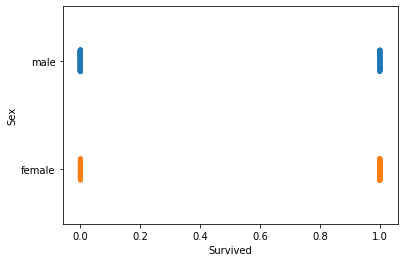

In [45]:
sns.stripplot(x = 'Survived', y = 'Sex', data = titanic)

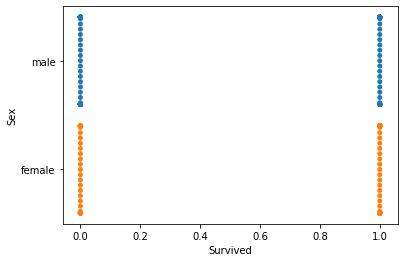

In [46]:
sns.swarmplot(x = 'Survived', y = 'Sex', data = titanic)

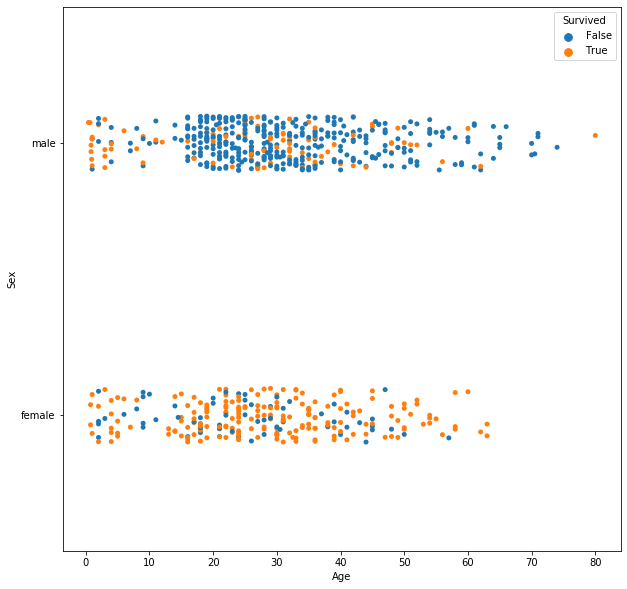

In [47]:
plt.figure(figsize = (10, 10))
sns.stripplot(x = 'Age', y = 'Sex', hue = 'Survived', data = titanic)

## Plotting Various Features

### Sepal Length vs Petal Length

In [48]:
plt.figure(figsize = (10, 10))
sns.stripplot(x = 'sepal_length', y = 'petal_length', hue = 'species', data = iris)

NameError: name 'iris' is not defined

<Figure size 720x720 with 0 Axes>

### Sepal Width vs Petal Width

In [ ]:
plt.figure(figsize = (10, 10))
sns.stripplot(x = 'sepal_width', y = 'petal_width', hue = 'species', data = iris)

### Sepal Length vs Sepal Width

In [ ]:
plt.figure(figsize = (10, 10))
sns.stripplot(x = 'sepal_width', y = 'sepal_length', hue = 'species', data = iris)

### Sepal Length vs Petal Length

In [ ]:
plt.figure(figsize = (10, 10))
sns.stripplot(x = 'sepal_length', y = 'petal_length', hue = 'species', data = iris)

### Sepal Ratio vs Petal Ratio

In [ ]:
plt.figure(figsize = (10, 10))
sns.stripplot(x = 'sepal_ratio', y = 'petal_ratio', hue = 'species', data = iris)